# Validation of Korteweg-de Vries Solver against Analytical Solution

The Korteweg-de Vries (KdV) equation in this form

$$
\frac{\partial u}{\partial t} - \frac{6}{2} \frac{\partial u^2}{\partial x} + \frac{\partial^3 u}{\partial x^3} = 0
$$

has an analytical solution in the form of a soliton (https://en.wikipedia.org/wiki/Korteweg%E2%80%93De_Vries_equation#One-soliton_solution) as

$$
u(t, x) = - \frac{1}{2} c \text{sech}^2\left(\frac{\sqrt{c}}{2} (x - c t - a)\right)
$$

where $c$ is the speed of the soliton and $a$ is the initial position of the
soliton. This solution is valid if the domain is infinite, i.e., $x \in
\mathbb{R}$. Approximately, we can also use it for periodic boundary conditions.

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [2]:
import exponax as ex

In [3]:
# The hyperbolic secant is not part of `jax.numpy` so we define it here
sech = lambda x: 1 / jnp.cosh(x)

In [4]:
c = 5.0
a = 10.0
analytical = lambda t, x: -1 / 2 * c * (sech(jnp.sqrt(c) / 2 * (x - c * t - a))) ** 2

In [5]:
L = 20.0
N = 256
DT = 0.001

In [6]:
grid = ex.make_grid(1, L, N)

2024-09-12 10:57:05.221505: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
u_0 = analytical(0, grid)

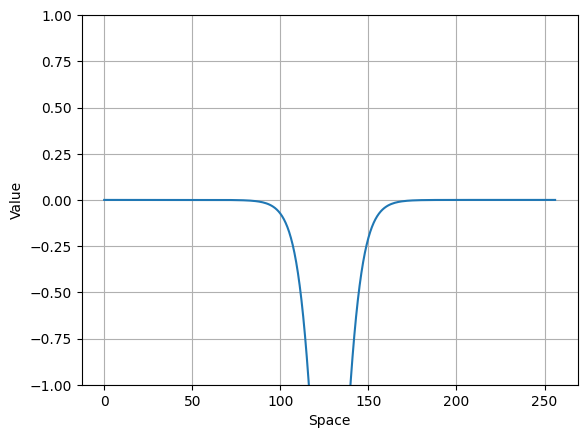

In [8]:
ex.viz.plot_state_1d(u_0)

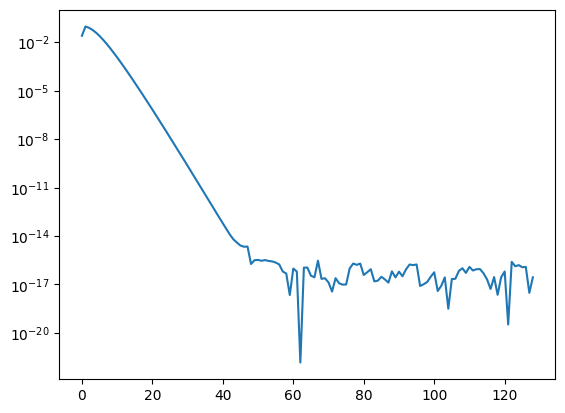

In [9]:
plt.semilogy(ex.get_spectrum(u_0)[0])

In [10]:
# Using the settings as described above. We have to deactivate the diffusivity
# and hyper-diffusivity
kdv_stepper = ex.stepper.KortewegDeVries(
    1,
    L,
    N,
    DT,
    convection_scale=-6,
    diffusivity=0.0,
    dispersivity=1.0,
    hyper_diffusivity=0.0,
)

In [11]:
trj_stepper = ex.rollout(kdv_stepper, 5000, include_init=True)(u_0)

In [12]:
trj_analytical = jax.vmap(
    analytical,
    in_axes=(0, None),
)(jnp.arange(5000 + 1) * DT, grid)

The KdV stepper qualitatively correctly propagates the soliton. Of course, the
analytical solution exits the domain on the right while the numerical solution
wraps around the domain.

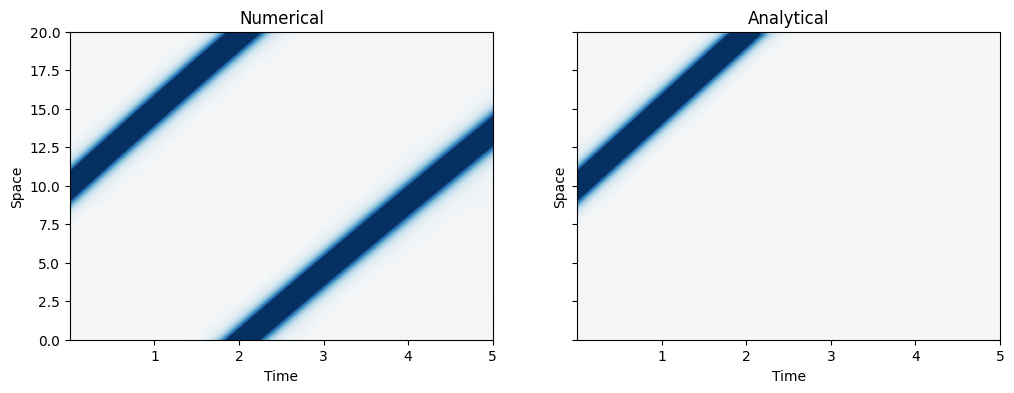

In [13]:
ex.viz.plot_spatio_temporal_facet(
    jnp.concatenate([trj_stepper, trj_analytical], axis=1),
    domain_extent=kdv_stepper.domain_extent,
    dt=kdv_stepper.dt,
    figsize=(12, 4),
    grid=(1, 2),
    titles=["Numerical", "Analytical"],
)

Extract the state after one time unit

In [14]:
stepper_state_after_one = trj_stepper[1000]
analytical_state_after_one = trj_analytical[1000]

The numerical solution produced some minor spurious oscillations likely due to
the absence of a diffusion term.

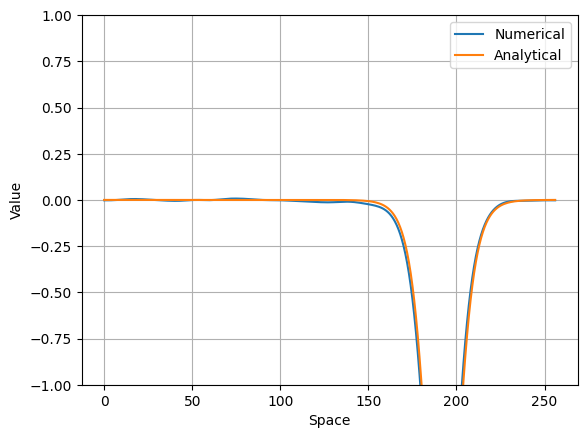

In [15]:
ex.viz.plot_state_1d(
    jnp.concatenate([stepper_state_after_one, analytical_state_after_one]),
    labels=["Numerical", "Analytical"],
)

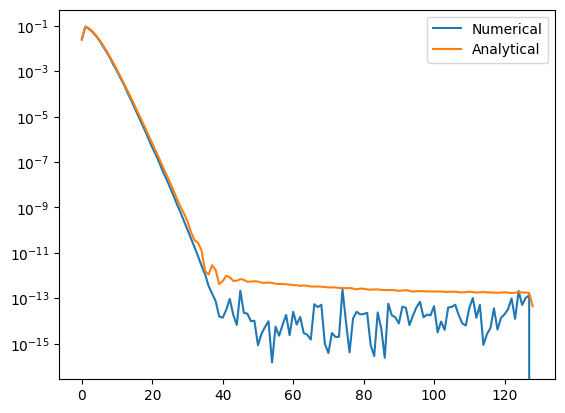

In [16]:
plt.semilogy(ex.get_spectrum(stepper_state_after_one)[0], label="Numerical")
plt.semilogy(ex.get_spectrum(analytical_state_after_one)[0], label="Analytical")
plt.legend()